IA & Data science -- 2017-2018
--------
*&copy; Equipe pédagogique: Ludovic Denoyer, Thibault Laugel, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander*

# TD-TME06: méthodes d'ensembles

L'objectif de ce TP est d'implémenter des méthodes d'ensembles et de les évaluer: l'algorithme de bagging appliqué aux arbres de décision, dans un premier temps, puis au perceptron ensuite.

Comme précédemment, on se restreint au cas binaire où les données sont étiquetées $+1$ ou $-1$. De plus, on ne considére que le cas où les attributs sont tous numériques.

<font size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

ZHONG_YUCHEN

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: envoyer le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers à envoyer, vous les joignez au message.

## Questions de cours (à faire chez vous, sur papier)

Pour vous entraîner sans machine... *(exercice de l'examen 2017)*

Soit $V=\{v_{1}, v_{2},..., v_{n}\}$ un ensemble de $n$ valeurs réelles ordonnées,
  telles que $v_1 \geq v_2 \geq \ldots \geq v_{n}$.. On note $\bar{v}$ la valeur moyenne de $V$. La variance de $V$, $var(V)$ est définie par:
$var(V) = \frac{1}{n} \sum_{i=1}^{n} (v_{i} - \bar{v})^2$. 

Et soit $W=\{w_{1}, w_{2},..., w_{n}\}$ tel que,pour tout $i=1,...,n$.


** [Q] ** Donner l'expression de $\bar{v}$ en fonction des valeurs de $V$.

** [Q] **  Montrer que $var(aV+b) = a^2 var(V)$.

** [Q] ** Donner l'expression de $V\cdot W$ (le produit scalaire) en fonction des coordonnées
   de $V$ et de $W$.
   
** [Q] ** Comment doit-on définir $W$ si on souhaite que $V\cdot W = \bar{v}$ ?


** [Q] ** Comment doit-on définir $W$ si on souhaite que
   $V\cdot W = \displaystyle\max_{i=1,...n} v_i$ ? Même question si on souhaite que
   $V\cdot W = \displaystyle\min_{i=1,...n} v_i$ ?

** [Q] ** Soit un entier $k$ tel que $0<k\leq n$. Proposer une définition de $W$ qui, par le
   calcul du produit scalaire, permet de ne tenir compte, de façon équitable, que des $k$
   valeurs les plus élevées de $V$.



## Préparation


In [1]:
#imports utiles
import numpy as np
import pandas as pd

On utilise la classe <code>LabeledSet</code> pour stocker les données d'apprentissage, de validation et de test.

In [2]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

Pour tester les fonctions à implémenter dans cette séance, on utilise la base d'exemples suivante :

In [3]:
# Base d'exemples pour tester les fonctions:
set_exemples = LabeledSet(2)
set_exemples.addExample([2.10492662303,1.10648470933],1)
set_exemples.addExample([0.297525816499,-0.662504551625],1)
set_exemples.addExample([1.6694258992,0.313687975072],1)
set_exemples.addExample([1.20583098523,3.50817309097],1)
set_exemples.addExample([1.13739407316,1.96688273992],1)
set_exemples.addExample([2.32319808376,0.536577798714],1)
set_exemples.addExample([-0.953004346997,0.596926923927],1)
set_exemples.addExample([1.00574784804,-0.0959606771199],1)
set_exemples.addExample([0.747509778063,0.429544908608],1)
set_exemples.addExample([1.39048336283,0.442578873406],1)
set_exemples.addExample([0.0470799329584,-1.97596265858],-1)
set_exemples.addExample([-0.673998013071,0.0693931940855],-1)
set_exemples.addExample([-0.84587451642,0.761766191612],-1)
set_exemples.addExample([-1.39596839858,-0.943807082082],-1)
set_exemples.addExample([0.319301767707,0.566169775123],-1)
set_exemples.addExample([1.43459714786,0.935712030926],-1)
set_exemples.addExample([-1.69323475458,-1.89563184035],-1)
set_exemples.addExample([0.81167008598,-1.17927660655],-1)
set_exemples.addExample([-1.03264043689,-1.08118488864],-1)
set_exemples.addExample([0.609517439986,-2.88593327349],-1)

Pour afficher, nous utilisons la fonction <code>plot2DSet()</code> déjà vue dans les séances précédentes. 


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    plt.scatter(S_pos[:,0],S_pos[:,1],marker='o')
    plt.scatter(S_neg[:,0],S_neg[:,1],marker='x')


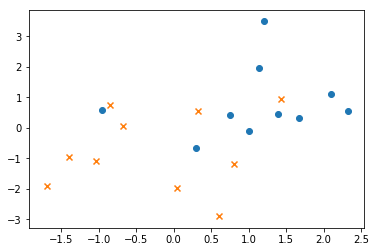

In [5]:
# Essai de la fonction : (the_set : variable du dataset généré précédemment)
plot2DSet(set_exemples)

### Les classifieurs

On reprend ici la classe <code>Classifier</code> qui sert encore de classe de base pour implémenter un nouveau classifieur.

In [6]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    # Permet d'entrainer le modele sur un ensemble de données étiquetés
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer le taux de bonne classification
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc


On reprend aussi la fonction <code>plot_frontiere</code> pour dessiner la frontière de décision d'un classifieur. 

In [7]:
def plot_frontiere(set,classifier,step=10):
    """ LabeledSet * Classifier * int -> NoneType
        Remarque: le 3e argument est optionnel et donne la "résolution" du tracé
        affiche la frontière de décision associée au classifieur
    """
    mmax=set.x.max(0)
    mmin=set.x.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    plt.contourf(x1grid,x2grid,res,colors=["red","cyan"],levels=[-1000,0,1000],linewidth=2)

## Etape 1: Bagging d'arbres de décision

Dans cette étape, on procède à l'implémentation de l'algorithme du bagging. Dans un premier temps, le classifieur que l'on utilise est celui des arbres de décision.

### Classifieurs par arbres de décision
Reprendre ici les fonctions réalisées pour l'implémentation des arbres de décision : <code>classe_majoritaire()</code>, <code>shannon()</code>, <code>entropie()</code>, <code>discretise()</code>, <code>divise()</code>, et <code>construit_AD()</code>.
Ainsi que les classes <code>ArbreBinaire</code> et <code>ArbreDecision</code>.


In [11]:
import math
#Alors, cette fonction doit rendre la classe dont les éléments encore plus !!
def classe_majoritaire(the_set):
    #Toutes les Xs dans l'ensemble the_set dont les Ys = +1 ou -1
    list_plus_1 = the_set.x[np.where(the_set.y == 1),:]
    list_moins_1 = the_set.x[np.where(the_set.y == -1),:]
    if ( len(list_plus_1[0]) >= len(list_moins_1[0]) ):
        return +1;
    else:
        return -1;

#Si cette fonction rend un 0 soit une erreur de la distribution, sinon rend l'entropie de Shannon != 0 
def shannon(distribution):
    if(min(distribution) < 0 or max(distribution) > 1):
        print("ce n'est pas une probabilité, et rendre 0")
        return 0;
    if(sum(distribution) != 1):
        print("les sommes de probas ne sont pas 1 et rendre 0")
        return 0;
    
    #Calcule l'entropie 
    k = len(distribution)
    entropie = 0
    for p in distribution:
        if p != 0 :
            entropie += -p*math.log(p,k);
    return entropie;

def entropie(the_set):
    p_plus_1 = float(len(the_set.x[np.where(the_set.y == 1),:][0]))/the_set.size()
    p_moins_1 = float(len(the_set.x[np.where(the_set.y == -1),:][0]))/the_set.size()
    distribution = [p_plus_1,p_moins_1]
    return shannon(distribution)

def discretise(LSet, col):
    """ LabelledSet * int -> tuple[float, float]
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col])[0] == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)


def divise(LSet,att,seuil):
    taille=LSet.size()
    i=0
    linf=LabeledSet(2)
    lsup=LabeledSet(2)
    while (i<taille):
        a=LSet.getX(i)
        if (a[att]<=seuil):
            linf.addExample(LSet.getX(i),LSet.getY(i))
        else:
            lsup.addExample(LSet.getX(i),LSet.getY(i))
        i=i+1
    #print(linf.x)
    #print(linf.y)
    #print("=============================================")
    #print(lsup.x)
    #print(lsup.y)
    return (linf,lsup)


import graphviz as gv

class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Gauche (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, "attr: "+str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g

    
def construit_AD(LSet, epsilon):
    un_arbre = ArbreBinaire();
    if(entropie(LSet) <= epsilon):
        feuille = ArbreBinaire();
        feuille.ajoute_feuille(classe_majoritaire(LSet));
        feuille.est_feuille();
        return feuille;
    else:
        seuiles =[]
        entropies = []
        for c in range(LSet.getInputDimension()):
            seuile, ent = discretise(LSet,c);
            seuiles.append(seuile);
            entropies.append(ent);
            
        index = entropies.index(min(entropies));    
        Linf, Lsup = divise(LSet,index,seuiles[index])
        un_arbre.ajoute_fils(construit_AD(Linf,epsilon),construit_AD(Lsup,epsilon),index,seuiles[index])


    return un_arbre;


class ArbreDecision(Classifier):
    # Constructeur
    def __init__(self,epsilon):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD(set,self.epsilon)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        nb_ok = 0
        for i in range(dataset.size()):
            output = self.predict(dataset.getX(i))
            if (output * dataset.getY(i) > 0):
                nb_ok = nb_ok + 1
        acc = nb_ok / (dataset.size() * 1.0)
        return acc

Ainsi, vous devez donc pouvoir utiliser à partir d'ici la classe <code>ArbreDecision</code>.

Par exemple, sur la base <code>set_exemples</code>:

accuracy: 1.0


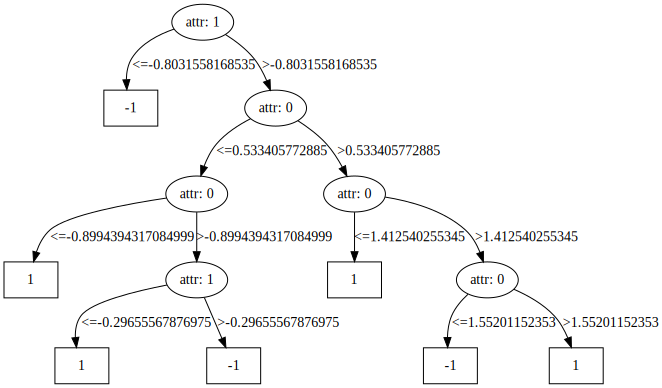

In [12]:
# un exemple d'utilisation:
ad=ArbreDecision(0.0)               # initialisation d'un arbre binaire qui utilise epsilon= 0.0
ad.train(set_exemples)              # construction de l'arbre à partir de la base jouet

print("accuracy:", ad.accuracy(set_exemples))    

#test de l'affichage 
ad.plot()


### Tirage aléatoire d'exemples

Le bootstrap s'effectue en tirant aléatoirement un échantillon de $m$ exemples à partir de la base d'apprentissage $X$ à partir duquel, on construit un classifieur.
Ce processus est répété $B$ fois.

Afin de ne pas alourdir la place mémoire nécessaire pour réaliser un tel tirage, on ne travaille que sur les indices des exemples dans la base. Un **échantillon de $X$ est donc un vecteur d'entiers** qui représentent les indices des exemples choisis.


#### Tirages aléatoires en Python

Consulter la librairie Python random qui propose différentes fonctions utiles pour implémenter le tirage aléatoire du bootstrap.

Par exemple, la fonction <code>sample()</code> de la librairie <code>random</code> rend une sélection aléatoire dans une population donnée en réalisant un tirage sans remise.

Pour tester, exécuter plusieurs fois les instructions de la boîte suivante :

In [16]:
import random
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
EchL = random.sample(L,6)               # tirage de 6 éléments de L
print("Echantillon: ",EchL)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Echantillon:  [4, 6, 7, 5, 1, 0]


La fonction <code>choice()</code> permet de choisir aléatoirement un élément:

In [18]:
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
elt = random.choice(L)                  # choix d'un élémént
print("Element choisi: ",elt)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Element choisi:  3


<font size="+1">**[Q]**</font> Ecrire une fonction <code>tirage()</code> qui étant donné un vecteur d'entiers $VX$ qui représente l'ensemble des indices des exemples d'une base d'apprentissage $X$, un entier $m$, et un booléen $r$, rend un vecteur de $m$ indices choisis aléatoirement dans $VX$. Si le booléen $r$ est vrai, le tirage s'effectue *avec remise*, sinon il s'effectue *sans remise*.

In [37]:
def tirage(vecteurX, m, r):
    res = []
    IndexVX = [i for i in range(len(vecteurX))]
    if(r): #tirage avec remise
        i = 0
        while(i<m):
            res.append(random.choice(IndexVX))
            i = i+1
        return res
    else:
        return random.sample(IndexVX,int(m))

Exemples :

In [38]:
L= [i for i in range(0,10)]    # construction de la liste des entiers de 0 à 100
tirage(L,8,True)               # tirage avec remise

[4, 9, 2, 9, 9, 3, 3, 1]

In [39]:
tirage(L,8,False)               # tirage sans remise

[2, 1, 3, 6, 9, 8, 4, 5]

<font size="+1">**[Q]**</font> En utilisant la fonction précédente, écrire la fonction <code>echantillonLS()</code> qui, étant donné un <code>LabeledSet</code> $X$, un nombre entier $m$, et un booléen rend un échantillon de $X$ de taille $m$ sous la forme d'un <code>LabeledSet</code>. L'échantillon est obtenu par un tirage avec remise si le booléen est True, sinon, il est obtenu sans remise.

In [51]:
def echantillonLS(X, m, r): # X est un LabeledSet
    IndexVX = [i for i in range(0,X.size())]
    IndexExemples = tirage(IndexVX,m,r)
    LSet = LabeledSet(X.getInputDimension())
    for indice in IndexExemples:
        LSet.addExample(X.getX(indice),X.getY(indice))
    return LSet

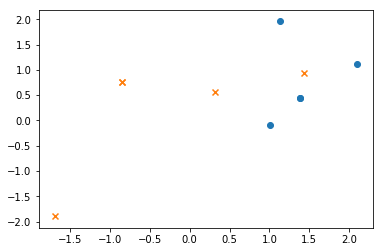

In [52]:
E = echantillonLS(set_exemples,10,True)
plot2DSet(E)

<font size="+1">**[Q]**</font> Ecrire la classe <code>ClassifierBaggingTree</code>, dérivée de la classe <code>Classifier</code>, qui permet d'implémenter un bagging d'arbres de décision. Les spécifications de cette classe sont :
- la création de l'ensemble nécessite les paramètres suivants : 
    - le nombre d'arbres à construire, 
    - le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon, 
    - la valeur de seuil d'entropie pour arrêter la construction de chaque arbre, 
    - et un booléen qui précise si un échantillon est tiré avec ou sans remise
- l'apprentissage (méthode <code>train()</code>) construit autant d'arbres que précisé à la création. Chaque arbre est construit à partir d'un échantillon de la base d'apprentissage (<code>LabeledSet</code>) donnée en argument. Les arbres construits sont stockés dans un ensemble Python.
- la prédiction (méthode <code>predict()</code>) classe un exemple par vote de tous les arbres de la forêt. Si la somme des votes est positive ou nulle, la classe rendue est +1, sinon, la classe rendue est -1.

In [59]:
class ClassifierBaggingTree(Classifier):
    # Constructeur
    def __init__(self,nbArbres,pourcentageExms,epsilon, r):
        self.nbArbres = nbArbres
        self.pourcentageExms = pourcentageExms
        self.epsilon = epsilon
        self.r = r
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        somme =  0.0
        for arbre in self.list_Arbres:
            classe = arbre.classifie(x)
            if (classe == 1):
                somme += 1.0
            else: somme -=1.0
        if(somme >= 0.0):
            return +1
        else: 
            return -1
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        self.set=set
        self.list_Arbres = []
        for i in range(self.nbArbres):
            IndexEchant = echantillonLS(set,self.pourcentageExms*set.size(),self.r)
            self.list_Arbres.append(construit_AD(IndexEchant,self.epsilon))

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        nb_ok = 0
        for i in range(dataset.size()):
            output = self.predict(dataset.getX(i))
            if (output * dataset.getY(i) > 0):
                nb_ok = nb_ok + 1
        acc = nb_ok / (dataset.size() * 1.0)
        return acc

exemple: 0  vraie classe =  [1] - classe trouvee =  1
exemple: 1  vraie classe =  [1] - classe trouvee =  1
exemple: 2  vraie classe =  [1] - classe trouvee =  1
exemple: 3  vraie classe =  [1] - classe trouvee =  1
exemple: 4  vraie classe =  [1] - classe trouvee =  1
exemple: 5  vraie classe =  [1] - classe trouvee =  1
exemple: 6  vraie classe =  [1] - classe trouvee =  1
exemple: 7  vraie classe =  [1] - classe trouvee =  1
exemple: 8  vraie classe =  [1] - classe trouvee =  1
exemple: 9  vraie classe =  [1] - classe trouvee =  1
exemple: 10  vraie classe =  [-1] - classe trouvee =  -1
exemple: 11  vraie classe =  [-1] - classe trouvee =  1
exemple: 12  vraie classe =  [-1] - classe trouvee =  1
exemple: 13  vraie classe =  [-1] - classe trouvee =  -1
exemple: 14  vraie classe =  [-1] - classe trouvee =  -1
exemple: 15  vraie classe =  [-1] - classe trouvee =  1
exemple: 16  vraie classe =  [-1] - classe trouvee =  -1
exemple: 17  vraie classe =  [-1] - classe trouvee =  1
exemple:

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


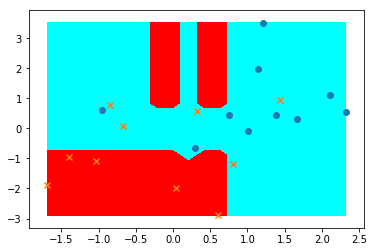

In [61]:
foret = ClassifierBaggingTree(10,0.3,0.0,True)
foret.train(set_exemples)
for i in range(set_exemples.size()):
    print("exemple:",i," vraie classe = ", set_exemples.getY(i), "- classe trouvee = ", foret.predict(set_exemples.getX(i)))
    
plot_frontiere(set_exemples,foret,20)
plot2DSet(set_exemples) 

print("\naccuracy totale:",foret.accuracy(set_exemples))

### Expérimentations

<font size="+1">**[Q]**</font> Expérimenter l'algorithme précédent de la façon suivante :
- générer une base d'apprentissage $X$ contenant au moins 1000 exemples ;
- réaliser un échantillon de cette base contenant 50 exemples de chaque classe. Soit $E$ cet échantillon, et soit $F$ l'ensemble des exemples de $X$ qui ne sont pas dans $E$ ;
- réaliser un apprentissage par bagging sur $F$ et évaluer le taux de prédiction du modèle obtenu sur $E$ ;
- construire la courbe donnant le taux de prédiction obtenu en augmentant la taille de la forêt d'arbres de 1 à 100 arbres. 

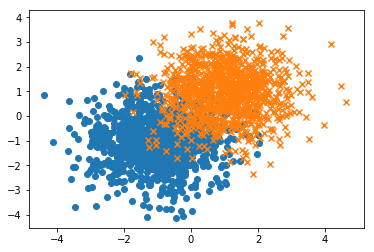

In [66]:
def generer_exemple(mean=0):
    """Genere un exemple"""
    mean = [mean, mean]
    cov = [[1, 0], [0, 1]]
    return np.random.multivariate_normal(mean, cov)

def generer_exemples(nombre_exemples, mean=0):
    """ Genere une liste de taille 'nombre_exemple' d'exemples """
    exemples = list()
    for _ in range(nombre_exemples):
        exemples.append(generer_exemple(mean))   
    return exemples

def ajouter_exemples_aleatoires(the_set, nombre_exemples, mean, labels):
    """ Ajoute dans 'the_set' un total de 'nombre_exemples' exemples
    associés aleatoirement à un label contenu dans 'labels'. """
    from random import choice
    exemples = generer_exemples(nombre_exemples, mean)
    for exemple in exemples:
        the_set.addExample(exemple, choice(labels))
        
X = LabeledSet(2) #set_apprentissage = X
ajouter_exemples_aleatoires(X, 1000, 1, [-1])
ajouter_exemples_aleatoires(X, 1000, -1, [1])
plot2DSet(X) 

E = LabeledSet(2) # E est un echantillon
F = LabeledSet(2) # F est un ensemble des exemples de X qui ne sont pas dans E

def E_F(X,E,F,n=50):
    i = 0
    while(i < (X.size()/2)):
        if(i < n):
            E.addExample(X.getX(i),X.getY(i))
            i +=1
        else:
            F.addExample(X.getX(i),X.getY(i))
            i +=1
    i = 1000
    while (i<X.size()):
        if(i < n+1000):
            E.addExample(X.getX(i),X.getY(i))
            i +=1
        else:
            F.addExample(X.getX(i),X.getY(i))
            i +=1
E_F(X,E,F,50)


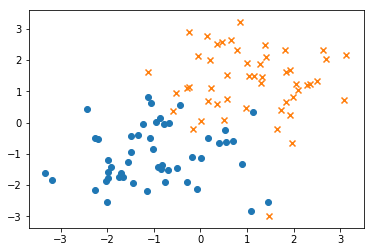

In [65]:
plot2DSet(E)

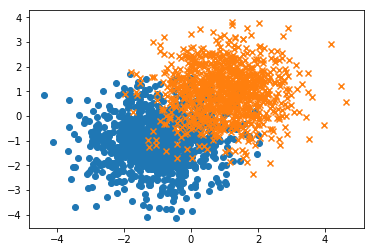

In [67]:
plot2DSet(F)

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


0.93

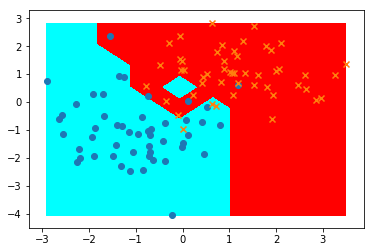

In [69]:
foret = ClassifierBaggingTree(10,0.3,0.0,True)
foret.train(F)
plot_frontiere(E,foret)
plot2DSet(E)
foret.accuracy(E)

In [70]:
# Réaliser un apprentissage par bagging sur E et évaluer le taux de prédiction du modèle sur F
foret20 =  ClassifierBaggingTree(20,0.3,0.0,True)
foret20.train(E)
print("Bagging : 20 trees: accuracy totale: train=%.4f test=%.4f"%(foret20.accuracy(E),foret20.accuracy(F)))

Bagging : 20 trees: accuracy totale: train=0.9400 test=0.8905


In [71]:
lx=[]
ly=[]
lz=[]
i=1

while (i<101):
    foret = ClassifierBaggingTree(i,0.3,0.0,True)
    foret.train(F)
    lx.append(i)
    ly.append(foret.accuracy(E))
    lz.append(foret.accuracy(F))
    i=i+10
    
print(lx)
print(lz)
print(ly)

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]
[0.9126315789473685, 0.9473684210526315, 0.9484210526315789, 0.9489473684210527, 0.9468421052631579, 0.9436842105263158, 0.9468421052631579, 0.9421052631578948, 0.9442105263157895, 0.9436842105263158]
[0.9, 0.91, 0.92, 0.92, 0.93, 0.93, 0.93, 0.93, 0.93, 0.94]


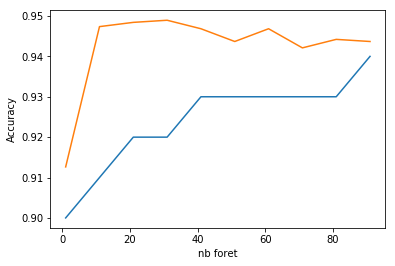

In [72]:
import matplotlib.pyplot as plt

plt.plot(lx,ly)  # on utilise la fonction sinus de Numpy
plt.plot(lx,lz)  # on utilise la fonction sinus de Numpy
plt.ylabel('Accuracy')
plt.xlabel("nb foret")
plt.show()

### Evaluation par la méthode "Out Of Bags"

<font size="+1">**[Q]**</font> Sur les mêmes données, réaliser une évaluation par la méthode "Out Of Bags" vue en cours. Construire la courbe donnant le taux de prédiction OOB en fonction de la taille de la forêt d'arbres.



In [ ]:
# Out Of Bags : OOB error : les données qui ne sont pas utilisées lx=[]
ly=[]
lz=[]
i=1

while (i<101):
    foret = ClassifierBaggingTree(i,0.3,0.0,True)
    foret.train(F)
    lx.append(i)
    ly.append(foret.accuracy(E))
    lz.append(foret.accuracy(F))
    i=i+10
    
print(lx)
print(lz)
print(ly)

import matplotlib.pyplot as plt

plt.plot(lx,ly)  # on utilise la fonction sinus de Numpy
plt.plot(lx,lz)  # on utilise la fonction sinus de Numpy
plt.ylabel('Accuracy')
plt.xlabel("nb foret")
plt.show()

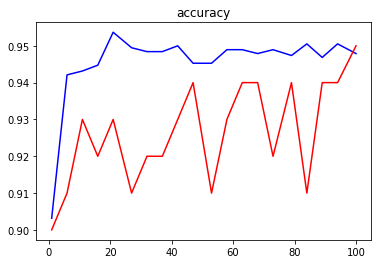

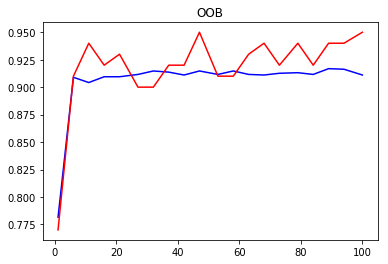

## Etape 3: Bagging de perceptrons

<font size="+1">**[Q]**</font> Ecrire et tester la classe <code>ClassifierBaggingPerceptron</code> qui implémente l'algorithme du bagging pour le perceptron.

In [77]:
import random
class Perceptron(Classifier):
    
    def __init__(self, input_dimension, learning_rate, nombre_iterations):
        self.input_dimension = input_dimension
        self.w = np.random.rand(input_dimension)
        self.n = learning_rate
        self.nb_Iteration = nombre_iterations
    
    def predict(self, x):
        z = np.dot(x, self.w)
        if z > 0:
            return +1
        else:
            return -1
    
    def train(self, labeledSet):
        self.labeledSet = labeledSet
        i = 0 
        while (i < self.nb_Iteration):
            index_aleatoire = random.randint(0,labeledSet.size()-1)
            if(labeledSet.getY(index_aleatoire)*self.predict(labeledSet.getX(index_aleatoire)) < 0 ): # Yifw(x) < 0 x est mal classé
                    self.w = self.w+self.n*labeledSet.getY(index_aleatoire)*labeledSet.getX(index_aleatoire)
            i +=1
        

In [78]:
class ClassifierBaggingPerceptron(Classifier):
    # Constructeur
    def __init__(self,input_dimension, nb_exemple, pourcentage, learning_rate, nombre_iterations,r):
        # valeur seuil d'entropie pour arrêter la construction
        self.input_dimension=input_dimension
        self.learning_rate=learning_rate
        self.nombre_iterations= nombre_iterations
        self.nb_exemple=nb_exemple
        self.pourcentage=pourcentage
        self.r=r
        self.liste=[]
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        somme=0
        for perce in self.liste:
            classe = perce.predict(x)
            if (classe == 1):
                somme=somme+1
            else:
                somme=somme-1
        if (somme>=0):
            return 1
        else : 
            return -1
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision
        self.liste=[]
        self.set=set
        for i in range (self.nb_exemple):
            m=self.pourcentage*set.size()
            echant=echantillonLS(set,m,self.r)
            self.liste.append(Perceptron(self.input_dimension,self.learning_rate,self.nombre_iterations))

In [80]:
set_apprentissage= LabeledSet(2) 
ajouter_exemples_aleatoires(set_apprentissage, 100, 1, [-1])
ajouter_exemples_aleatoires(set_apprentissage, 100, -1, [1])

set_test= LabeledSet(2) 
ajouter_exemples_aleatoires(set_test, 100, 1, [-1])
ajouter_exemples_aleatoires(set_test, 100, -1, [1])

# un exemple d'utilisation:
percep=Perceptron(2,0.2,100)           
percep.train(set_apprentissage)            
    
print("accuracy:", percep.accuracy(set_test))    


accuracy: 0.885


In [81]:
lx=[]
ly=[]
lz=[]
i=1

while (i<101):
    foret = ClassifierBaggingPerceptron(2,i,0.3,0.0,50,True)
    foret.train(F)
    lx.append(i)
    ly.append(foret.accuracy(E))
    lz.append(foret.accuracy(F))
    i=i+5
    
print(lx)
print(lz)
print(ly)

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]
[0.08421052631578947, 0.09105263157894737, 0.08263157894736842, 0.08315789473684211, 0.08105263157894736, 0.08263157894736842, 0.08210526315789474, 0.08, 0.08421052631578947, 0.08052631578947368, 0.08368421052631579, 0.08052631578947368, 0.08052631578947368, 0.08421052631578947, 0.08052631578947368, 0.08105263157894736, 0.08263157894736842, 0.08105263157894736, 0.08052631578947368, 0.08105263157894736]
[0.08, 0.09, 0.09, 0.08, 0.09, 0.09, 0.09, 0.09, 0.08, 0.08, 0.09, 0.08, 0.09, 0.08, 0.09, 0.09, 0.09, 0.08, 0.08, 0.09]


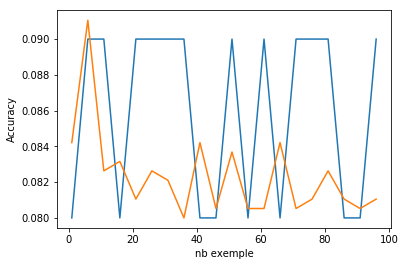

In [82]:
plt.plot(lx,ly)  # on utilise la fonction sinus de Numpy
plt.plot(lx,lz)  # on utilise la fonction sinus de Numpy
plt.ylabel('Accuracy')
plt.xlabel("nb exemple")
plt.show()

## Etape 4: expérimentation

<font size="+1">**[Q]**</font> Appliquer l'algorithme de bagging d'arbres de décision sur d'autres bases d'apprentissage. Construire la courbe donnant le taux de prédiction pour une forêt d'arbres variant de 1 à 200 arbres. 

Réaliser ensuite la même expérimentation avec un bagging de perceptrons.